In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available
print(f"on device: {device}")

on device: cuda


In [ ]:
IMAGE_DIMENSION = 512

# VGG -19 Model



**Diagram of model and display of layers**

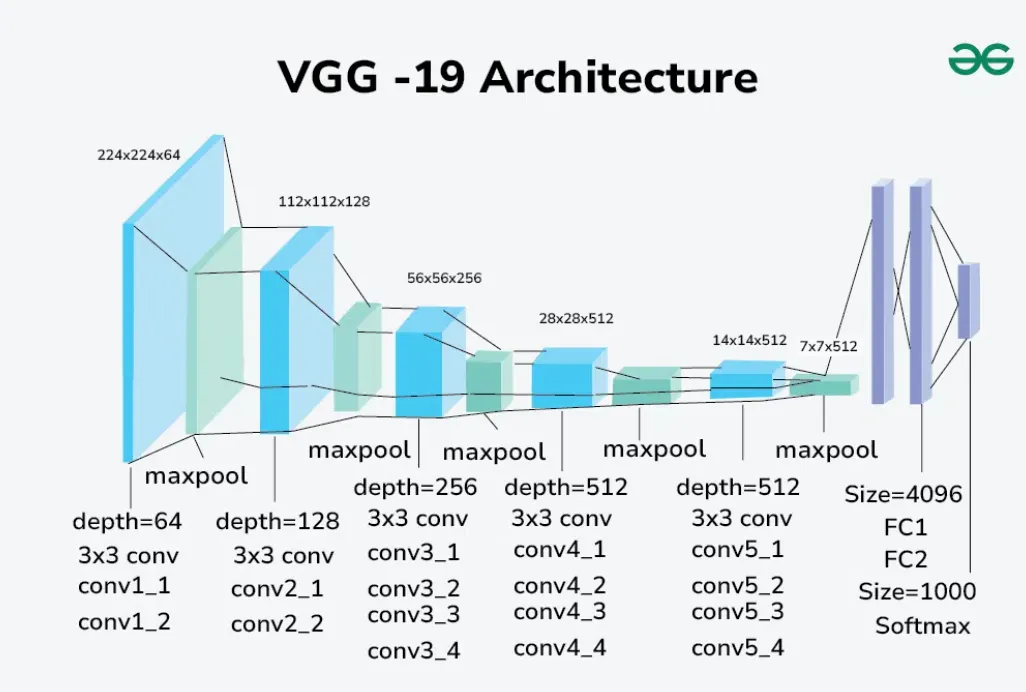

In [ ]:
print(vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device).eval())

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 69.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Image generation

**Network that is used to create feature map**

In [ ]:
class StyleTransfer(nn.Module):
    def __init__(self, content_layers, style_layers):
        super().__init__()
        self.model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.eval().to(device)

        for param in self.model.parameters():
             param.requires_grad = False

        mapping = self.__parse_model_conv_layers([*content_layers, *style_layers])

        self.__content_indices = sorted([mapping[name] for name in content_layers])
        self.__style_indices   = sorted([mapping[name] for name in style_layers])

    def forward(self, x):
        content_features = []
        style_features   = []

        for index, layer in enumerate(self.model):
            x = layer(x)
            if index in self.__content_indices:
                content_features.append(x)

            if index in self.__style_indices:
                style_features.append(x)

        return content_features, style_features


    def __parse_model_conv_layers(self, layers):
      mapping = {}
      counter_layer = 1
      counter_inside_layer = 1
      for index, layer in enumerate(self.model):
          if isinstance(layer, nn.Conv2d):
              name = f"conv{counter_layer}_{counter_inside_layer}"
              if name in layers:
                mapping[name] = index
              counter_inside_layer += 1
          elif isinstance(layer, nn.MaxPool2d):
                counter_layer += 1
                counter_inside_layer = 1

      return mapping

**Helper functions**

In [ ]:
convert_input = T.Compose([
    # parametrize image size
    T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    T.Lambda(lambda x: x.unsqueeze(0).to(device)),
])

In [ ]:
# Tensor to image transformation
def im_convert(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image * IMAGENET_STD + IMAGENET_MEAN  # Unnormalize
    return image.clip(0, 1)


In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G / (a * b * c * d)

**Upload of both images**

In [ ]:
from google.colab import files

print("Upload your content image:")
uploaded_content = files.upload()

# Assuming only one file is uploaded for content
for fn in uploaded_content.keys():
  input_content = fn
  print('User uploaded content file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_content[fn])))

Upload your content image:


Saving hallstatt.jpg to hallstatt.jpg
User uploaded content file "hallstatt.jpg" with length 10435057 bytes


In [ ]:
from google.colab import files

print("Upload your style image:")
uploaded_style = files.upload()

# Assuming only one file is uploaded for style
for fn in uploaded_style.keys():
  input_style = fn
  print('User uploaded style file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_style[fn])))

Upload your style image:


Saving starry-night.jpg to starry-night.jpg
User uploaded style file "starry-night.jpg" with length 615151 bytes


In [ ]:
def display_images(content, style):
  figure, axis = plt.subplots(1, 2)

  axis[0,].set_title("Content Image")
  axis[0].imshow(im_convert(content))

  axis[1].set_title("Style Image")
  axis[1].imshow(im_convert(style))

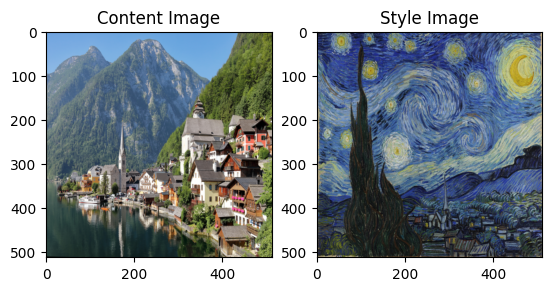

In [ ]:
content = convert_input(Image.open(input_content))
style = convert_input(Image.open(input_style))

display_images(content, style)

In [ ]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

alternative parameter for content layer is, content_layers = ['conv5_2']


copilot explanation: The choice between using **conv4_2** and **conv5_2** in neural style transfer affects how much detail and abstraction is preserved in the content representation.

If you're aiming for a more recognizable and structured output, stick with **conv4_2**. If you want a more abstract and heavily stylized result, **conv5_2** might be worth experimenting with.


Key Differences

1.) Detail vs Abstraction:
- **conv4_2** retains more fine-grained details like edges and shapes.
- **conv5_2** focuses on broader semantic structures, which can make the output more stylized but less faithful to the original content.

2.) Spatial Accuracy:
- **conv4_2** better preserves the layout and geometry of the content image.
- **conv5_2** may distort or simplify spatial relationships due to its deeper abstraction.

3.) Style Influence:
- **conv5_2** can make the style more dominant, as the content is less rigidly defined.
- **conv4_2** allows for a more balanced blend of content and style.




In [ ]:
model = StyleTransfer(content_layers, style_layers)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 79.0MB/s]


In [ ]:
content_image_layers, _ = model(content)
_, style_image_layers   = model(style)

style_image_layers = [gram_matrix(style) for style in  style_image_layers]

len(content_image_layers), len(style_image_layers)

(1, 5)

**Parameters of weights**

In [ ]:
STYLE_WEIGHT = 1e4
CONTENT_WEIGHT = 1

**Cost function used and weights**

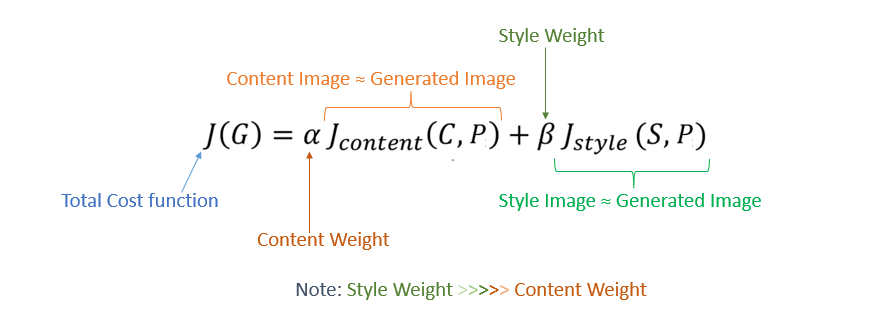

**Generate image**

In [ ]:
generated = 1e-1*torch.randn_like(content, device=device)
generated.requires_grad_(True)

optimizer = optim.LBFGS([generated])

**Run algorithm**

In [ ]:
num_steps = 500

optimizer_step = 0

for loop_step in range(num_steps):

    def run_optim():
        optimizer.zero_grad()

        global optimizer_step # Use global instead of nonlocal
        optimizer_step += 1

        content_generated, style_generated = model(generated)

        content_loss = 0
        for gen, target in zip(content_generated, content_image_layers):
            content_loss += F.mse_loss(gen, target)

        style_loss = 0
        for gen, target in zip(style_generated, style_image_layers):
            style_loss += F.mse_loss(gram_matrix(gen), target)

        content_loss *= CONTENT_WEIGHT
        style_loss   *= STYLE_WEIGHT

        total_loss =  style_loss + content_loss

        total_loss.backward()

        if optimizer_step % 50 == 0:
            print(f"optimizer_step/loop_step: {optimizer_step}/{loop_step}, total loss:  {total_loss.item()} , content loss: {content_loss.item()}, style loss: {style_loss.item()}") # Changed step to num_steps

        return total_loss.item()

    optimizer.step(run_optim)

optimizer_step/loop_step: 50/2, total loss:  3.8166286945343018 , content loss: 1.9439301490783691, style loss: 1.8726985454559326
optimizer_step/loop_step: 100/4, total loss:  2.419771194458008 , content loss: 1.331167459487915, style loss: 1.0886037349700928
optimizer_step/loop_step: 150/7, total loss:  2.028294324874878 , content loss: 1.1297897100448608, style loss: 0.8985045552253723
optimizer_step/loop_step: 200/9, total loss:  1.9013211727142334 , content loss: 1.0413516759872437, style loss: 0.8599695563316345
optimizer_step/loop_step: 250/12, total loss:  1.8322155475616455 , content loss: 0.9917594194412231, style loss: 0.8404561281204224
optimizer_step/loop_step: 300/14, total loss:  1.7865638732910156 , content loss: 0.9602503776550293, style loss: 0.8263134956359863
optimizer_step/loop_step: 350/17, total loss:  1.752849817276001 , content loss: 0.9363402128219604, style loss: 0.8165096044540405
optimizer_step/loop_step: 400/19, total loss:  1.72727632522583 , content loss

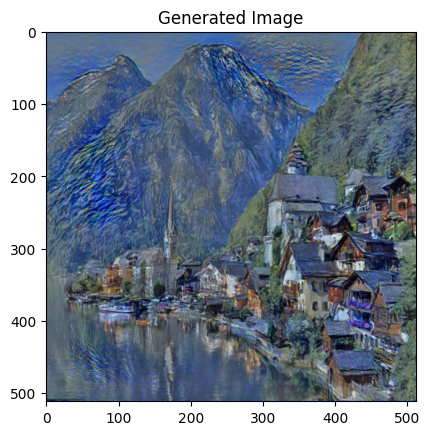

Parameters used: STYLE_WEIGHT: 10000.0, CONTENT_WEIGHT:  1


In [ ]:
print(f"Parameters used: STYLE_WEIGHT: {STYLE_WEIGHT}, CONTENT_WEIGHT:  {CONTENT_WEIGHT}")

# Display the generated image
plt.title("Generated Image")
plt.imshow(im_convert(generated))
plt.show()

# Tutorials

##Explanation of what calculation of gram matrix does

Gram matrix explanation references:

https://medium.com/data-science/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916

https://www.pluralsight.com/resources/blog/guides/implementing-artistic-neural-style-transfer-with-tensorflow-20


In [ ]:
example = torch.tensor(range(60)).view(4, 3, 5)

In [ ]:
example.shape, example

(torch.Size([4, 3, 5]),
 tensor([[[ 0,  1,  2,  3,  4],
          [ 5,  6,  7,  8,  9],
          [10, 11, 12, 13, 14]],
 
         [[15, 16, 17, 18, 19],
          [20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29]],
 
         [[30, 31, 32, 33, 34],
          [35, 36, 37, 38, 39],
          [40, 41, 42, 43, 44]],
 
         [[45, 46, 47, 48, 49],
          [50, 51, 52, 53, 54],
          [55, 56, 57, 58, 59]]]))

In [ ]:
gram_matrix(torch.unsqueeze(example, 0))

tensor([[ 16.9167,  43.1667,  69.4167,  95.6667],
        [ 43.1667, 125.6667, 208.1667, 290.6667],
        [ 69.4167, 208.1667, 346.9167, 485.6667],
        [ 95.6667, 290.6667, 485.6667, 680.6667]])

We basically do dot product of each feature vector with all other feature vectors,

since feature vectors are 2 dimensional we need to reshape them into one long vector, of size height * width

In [ ]:
C, H, W = example.shape
print(C, H, W)

# image dimension
N = H * W

F = example.view(C, N)

# Initialize Gram matrix
G = torch.zeros(C, C)

scale_factor = C * H * W

# Compute Gram matrix using nested loops
for i in range(C):
    for j in range(C):
        dot_product = 0.0
        for k in range(N):
            dot_product += F[i, k] * F[j, k]

        dot_product /= scale_factor
        G[i, j] = dot_product

print(G)

4 3 5
tensor([[ 16.9167,  43.1667,  69.4167,  95.6667],
        [ 43.1667, 125.6667, 208.1667, 290.6667],
        [ 69.4167, 208.1667, 346.9167, 485.6667],
        [ 95.6667, 290.6667, 485.6667, 680.6667]])


**Diagram of multiplication**

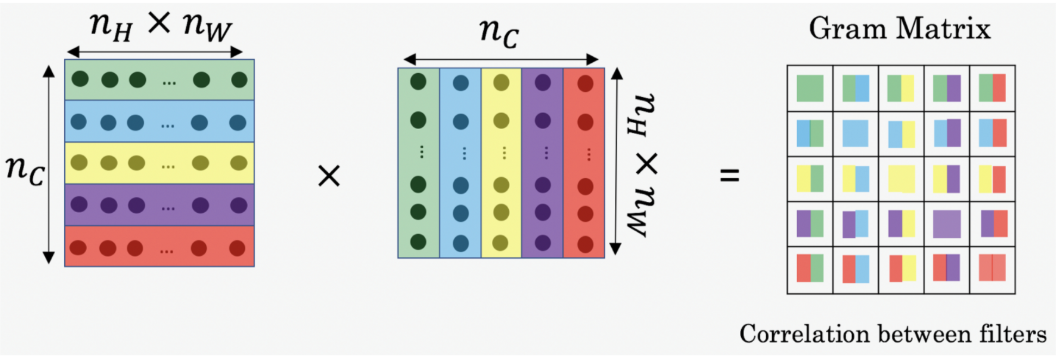

## Intuitive explanation of why gram matrix is used for style loss

The dot product between two vectors measures how similar they are—the more aligned the vectors, the larger the dot product.

We compute dot products between feature maps to build a Gram matrix, which captures how often different filters activate together across the image. A high value in the Gram matrix indicates strong correlation between patterns, while a low value suggests they rarely co-occur.

To compute these interactions, the 2D spatial structure of each feature map is flattened into a vector, which means we lose spatial information.

Final result is a representation of style that reflects texture and pattern relationships, independent of where they appear in the image.

##**Why does optimizer use closure, and why do certain calls need to be defined**

https://docs.pytorch.org/docs/stable/optim.html#optimizer-step-closure

Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model. The closure should clear the gradients, compute the loss, and return it.


```
for input, target in dataset:
    def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)
```
